<a href="https://colab.research.google.com/github/KsBrume/Load-a-van/blob/main/genetic_loading_van.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installing pygad for genetic algorithm

!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
# importing necessary libraries

import statistics
import time

import numpy as np
import pandas as pd
import pygad



In [ ]:
# defying constants


VAN_VOLUME = 1  # Van volume capacity of the van
TRY_NUMBER = 3  # number of tries for counting median fitness value for the same set of parameters


# some possible types of prameters for the genetic algorithm
# which we will use in search for optimal set of parameters
CROSSOVER_TYPE_LIST = ['single_point', 'two_points', 'scattered']
CROSSOVER_PROBABILITY_LIST = list(map(lambda x: x * 0.1, list(range(7, 10, 1))))
MUTATION_PROBABILITY_LIST = list(map(lambda x: x * 0.1, list(range(7, 10, 1))))
MUTATION_PERCENT_GENES_LIST = list(range(10, 60, 20))

In [ ]:
# data with household appliancies

df_appliances = pd.read_excel('/content/drive/MyDrive/genetic load van/products.xlsx')
df_appliances

,Product,Space,Price,Quantity
0,Refrigerator A,0.751000,999.90,3
1,Cell phone,0.000009,2199.12,2
2,TV 55,0.400000,4346.99,5
3,TV 50,0.290000,3999.90,5
4,TV 42,0.200000,2999.00,5
5,Notebook A,0.003500,2499.90,4
6,Ventilator,0.496000,199.90,12
7,Microwave A,0.042400,308.66,7
8,Microwave B,0.054400,429.90,7
9,Microwave C,0.031900,299.29,9


In [ ]:
# all the data is clean and represented
df_appliances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Product   14 non-null     object 
 1   Space     14 non-null     float64
 2   Price     14 non-null     float64
 3   Quantity  14 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 576.0+ bytes


In [ ]:
# first of all we should make a list of all items, for this purpose we will create custom class HouseholdAppliance

class HouseholdAppliance:
    """
    Class whish helps create instances of given appliances
    """

    def __init__(self, price: float, space: float, name: str):

        self.price = price  # price of the appliance
        self.space = space  # volume occupied
        self.name = name    # name of the appliance

    def __str__(self):
        return f" object: {self.name} \n price: {self.price} \n required space: {self.space} \n\n"


# data base of the given objects
appliance_base = []
all_volume = 0

for i in range(len(df_appliances)):
    for j in range(df_appliances.iloc[i]['Quantity']):
        # creating an object
        product = HouseholdAppliance(name=df_appliances.iloc[i]['Product'],
                                     space=df_appliances.iloc[i]['Space'],
                                     price=df_appliances.iloc[i]['Price'])
        # adding object to the base
        appliance_base.append(product)
        all_volume += df_appliances.iloc[i]['Space']

print('Total space required', all_volume)
# let's see which capacity is needed to transfer all household appliances
# it's obvious that the van with capacity which equals 1 or even 5 can't transfer all present items


Total space required 24.06371798000002


In [ ]:
# let's check quickly what we have now in our base

assert len(appliance_base) == df_appliances['Quantity'].sum(), 'The total quantity in the given dataset must be the same as the number of object in created base'

print('Products in our data base')
print([item.name for item in appliance_base])
print(f'Total number of household applience to transfer: {len(appliance_base)}')

Products in our data base
['Refrigerator A', 'Refrigerator A', 'Refrigerator A', 'Cell phone', 'Cell phone', 'TV 55', 'TV 55', 'TV 55', 'TV 55', 'TV 55', 'TV 50', 'TV 50', 'TV 50', 'TV 50', 'TV 50', 'TV 42', 'TV 42', 'TV 42', 'TV 42', 'TV 42', 'Notebook A', 'Notebook A', 'Notebook A', 'Notebook A', 'Ventilator', 'Ventilator', 'Ventilator', 'Ventilator', 'Ventilator', 'Ventilator', 'Ventilator', 'Ventilator', 'Ventilator', 'Ventilator', 'Ventilator', 'Ventilator', 'Microwave A', 'Microwave A', 'Microwave A', 'Microwave A', 'Microwave A', 'Microwave A', 'Microwave A', 'Microwave B', 'Microwave B', 'Microwave B', 'Microwave B', 'Microwave B', 'Microwave B', 'Microwave B', 'Microwave C', 'Microwave C', 'Microwave C', 'Microwave C', 'Microwave C', 'Microwave C', 'Microwave C', 'Microwave C', 'Microwave C', 'Refrigerator B', 'Refrigerator B', 'Refrigerator B', 'Refrigerator B', 'Refrigerator C', 'Refrigerator C', 'Notebook B', 'Notebook B', 'Notebook B', 'Notebook B', 'Notebook B', 'Notebook

In [ ]:
# Let's create fitness function which will help to maximize value of the transported objects
# This given problem can be considered as single-objective problem, so the function will return one value
# The sum value of the objects placed in the van


def fitness_func(ga_instance, genome, genome_idx) -> float:
    """
    fitness function of the genetic algorithm
    args:
        ga_instance: the instance of the pygad.GA class
        genone: current solution which needs to be evaluated
        appliance_base: all objects that we have (that can be transported)
        total_space: volume capacity of the van
    returns:
        sum_price: total value of the current solution
    """

    space = 0
    sum_price = 0.00000001

    for i, product in enumerate(appliance_base):
        if genome[i] == 1:
            space += product.space
            if space > VAN_VOLUME:
                return 0.00000001  # if the currect solution exceeds volume capacity than the fitness function will return 0
                                   # it's not exactly zero to avoid ZeroDivisionError
            sum_price += product.price

    return sum_price




In [ ]:
class TransportationGeneticOptimization:
    """
    Class which allows to choose better parameter for genetic algorithm
    also runs it and saves results
    """

    def __init__(self):
        """
        Constructor of the class
        define parameters of the future genetic algorithm
        """

        self.num_generations = 200  # number of generations
        self.num_parents_mating = 60  #according to research "Genetic algorithms with multi-parent recombination"
                                      #(A.E. Eiben, P-E. Rau6, Zs. Ruttkay) some problems require more parents for recombination
                                      # for the genetic algorithm to perform better
        self.sol_per_pop = 500  # number of solutions in each population
                                #(not being passed to GA instance directly in this case, used to define initial population parameter)

        # genetic representation of solution is a list of 0's and 1's (1 means that the item is present in the current set, 0 means that it's not)
        #self.initial_population = [list(np.random.choice([0, 1], len(appliance_base))) for i in range(sol_per_pop)]
        self.initial_population = [[1] * len(appliance_base) for i in range(self.sol_per_pop)] # expreriments have shown that this genetic
                                                                                               # representation performs better than the above one
                                                                                               # which means that initially it will be a list of ones
                                                                                               # than the alforithm will remove unnecessary items
                                                                                               # considering total fitness value of the current set of the appliancies
        self.parent_selection_type = 'random'  # random parent selection type
        self.keep_elitism = 70                 # 70 best solutions in the current generation is kept in the next generation
        self.gene_type = int                   # allows algorithm use only 0 and 1 without in-between values
        self.crossover_type = 'single_point'   # defines recombination type
        self.crossover_probability = 0.8       # the probability of selection a parent for applying crossover operation
        self.mutation_type = 'random'          # type of mutation operation
        self.mutation_probability = 0.7        # the probability of selecting a gene for applying the mutation operation
        self.mutation_percent_genes = 30       # percentage of genes to mutate
        self.solution = None                   # future solution of the genetic algorithm corresponding defined genetic representation
        self.solution_fitness = None           # fitness value of the solution
        self.params_df = None                  # dataset with results for different sets of parameters

    def choose_best_params(self, params_from_dataset=True, dataset_path=None):
        """
        Method which allows to try different values for some parameters and saves results to a separate dataset
        args:
            params_from_dataset: bool - if True than results are loaded from beforehand prepared dataset,
                                        otherwise - algorithm searches for the better parameters
            dataset_path: str - used if params from dataset is True
        """

        if not params_from_dataset:

            start = time.time()

            data_for_dataset = []
            for crossover_type in CROSSOVER_TYPE_LIST:
                for crossover_probability in CROSSOVER_PROBABILITY_LIST:
                    for mutation_probability in MUTATION_PROBABILITY_LIST:
                        for mutation_percent_genes in MUTATION_PERCENT_GENES_LIST:
                            parameter_list = [crossover_type, crossover_probability,
                                              mutation_probability, mutation_percent_genes]

                            # for each set of parametes we create an instance of the pygad.GA class
                            ga_instance = pygad.GA(num_generations=self.num_generations,
                                                   num_parents_mating=self.num_parents_mating,
                                                   fitness_func=fitness_func,
                                                   initial_population=self.initial_population,
                                                   gene_type = self.gene_type,
                                                   parent_selection_type=self.parent_selection_type,
                                                   keep_elitism=self.keep_elitism,
                                                   crossover_type=crossover_type,
                                                   crossover_probability=crossover_probability,
                                                   mutation_type=self.mutation_type,
                                                   mutation_percent_genes=mutation_percent_genes)
                            results_list = []
                            for i in range(TRY_NUMBER):
                                # we run the genetic algorithm several (TRY_NUMBER) times
                                ga_instance.run()
                                solution, solution_fitness, solution_idx = ga_instance.best_solution()
                                results_list.append(solution_fitness)

                            # we compute median and maximum fitness values for each set of parameters
                            median_fitness = statistics.median(results_list)
                            max_fitness = max(results_list)

                            parameter_list += [median_fitness, max_fitness]
                            data_for_dataset.append(parameter_list)

            end = time.time()
            print(f'Time to analize parameters: {round((end - start) / 60, 2)} min')

            # creating dataset with parameter values and corresponding fitness function values
            self.params_df = pd.DataFrame(data_for_dataset, columns=['crossover_type', 'crossover_probability', 'mutation_probability',
                                                                     'mutation_percent_genes', 'median_fitness', 'max_fitness'])
            self.params_df.to_csv('params_df.csv')

        else:
            self.params_df = pd.read_csv(dataset_path)

    def run_algorithm(self):
        """
        Method runs genetic algorithm
        """

        start = time.time()

        # we create an instance of the pygad.GA class
        ga_instance = pygad.GA(num_generations=self.num_generations,
                               num_parents_mating=self.num_parents_mating,
                               fitness_func=fitness_func,
                               initial_population=self.initial_population,
                               gene_type = self.gene_type,
                               parent_selection_type=self.parent_selection_type,
                               keep_elitism=self.keep_elitism,
                               crossover_type=self.crossover_type,
                               crossover_probability=self.crossover_probability,
                               mutation_type=self.mutation_type,
                               mutation_percent_genes=self.mutation_percent_genes,
                               save_solutions=True)

        ga_instance.run()
        end = time.time()
        print(f'Time of running the genetic algorithm: {round((end - start) / 60, 2)} min')

        ga_instance.plot_fitness()            #shows how the fitness evolves by generation
        ga_instance.plot_new_solution_rate()  # shows the number of new solutions explored in each solution

        self.solution, self.solution_fitness, solution_idx = ga_instance.best_solution()
        print(f"Parameters of the best solution :\n {self.solution}")
        print(f"Fitness value of the best solution = {self.solution_fitness}")

    def show_items_included(self):
        """
        Method runs some tests and shows which objects are chosen to be transported
        """

        total_price = 0     # sum price of the chosen objects
        occupied_space = 0  # sum occupied space of the chosen objects

        items_included = []
        for i, gene in enumerate(self.solution):
            if gene == 1:
                total_price += appliance_base[i].price
                occupied_space += appliance_base[i].space
                print(appliance_base[i])
                print()
                items_included.append([appliance_base[i].name, appliance_base[i].space, appliance_base[i].price])

        assert len(self.solution) == len(appliance_base), 'Size of solution must be the same as the total number of products'
        assert round(total_price) == round(self.solution_fitness), 'Total price and fitness value of the best solution must be the same'
        assert occupied_space < VAN_VOLUME, 'Total occupied space must be less or the same as volume capacity of the van'
        print(f'Total occupied space {occupied_space}')
        print(f'Total value of the transported objects {total_price}')

        result_df = pd.DataFrame(items_included, columns=['item', 'volume', 'price'])
        result_df.to_csv(f'result_df_{VAN_VOLUME}.csv')
        result_df






In [ ]:
# now let's try to find optimal values for some parameters

algorithm = TransportationGeneticOptimization()
algorithm.choose_best_params(params_from_dataset=False)

/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Time to analize parameters: 96.72 min


In [ ]:
# now let's see what results we got
# the algorith is likely to stuck in the local minima, that's why we needed to try to find better solutions

print('highest fitness value: ', algorithm.params_df['max_fitness'].apply('max'))
print('highest median fitness value: ', algorithm.params_df['median_fitness'].apply('max'))


# let's see which values parameters have given us the best results
algorithm.params_df[algorithm.params_df['max_fitness'] == algorithm.params_df['max_fitness'].apply('max')]

highest fitness value:  28395.640000010004
highest median fitness value:  28395.640000010004


,crossover_type,crossover_probability,mutation_probability,mutation_percent_genes,median_fitness,max_fitness
65,scattered,0.8,0.7,50,28395.64,28395.64
66,scattered,0.8,0.8,10,28395.64,28395.64
73,scattered,0.9,0.7,30,28395.64,28395.64


Van capacity:  1


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1162: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Time of running the genetic algorithm: 12.71 min


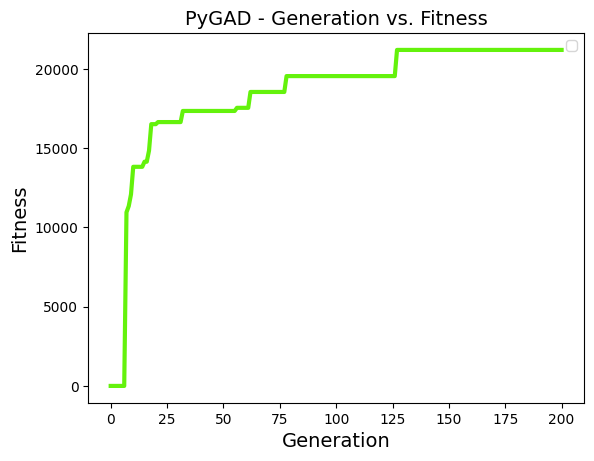

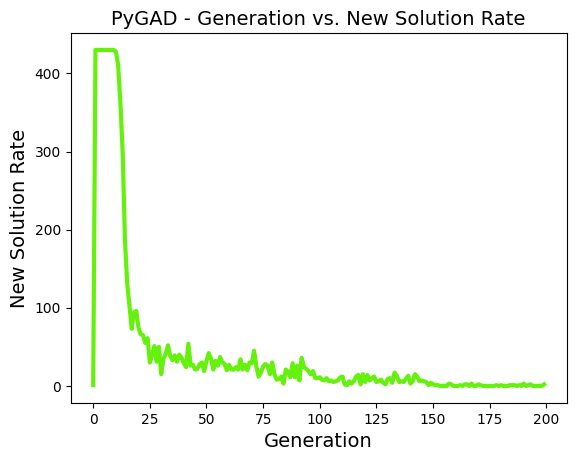

Parameters of the best solution :
 [0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Fitness value of the best solution = 21196.720000010002
 object: Cell phone 
 price: 2199.12 
 required space: 8.99e-06 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



Total occupied space 0.9870089899999999
Total value of the transported objects 21196.72
----------

Van capacity:  2


Time of running the genetic algorithm: 16.65 min


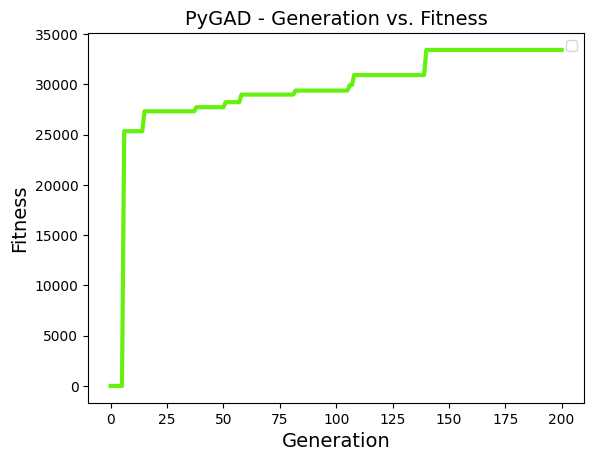

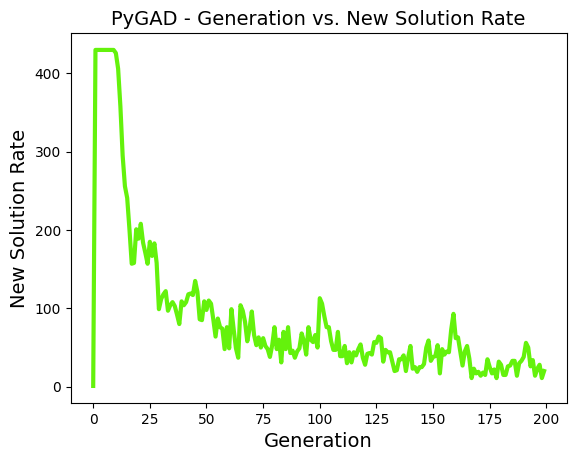

Parameters of the best solution :
 [0 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Fitness value of the best solution = 33437.81000001
 object: Cell phone 
 price: 2199.12 
 required space: 8.99e-06 



 object: Cell phone 
 price: 2199.12 
 required space: 8.99e-06 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



Total occupied space 1.9870179800000003
Total value of the transported objects 33437.810000000005
----------

Van capacity:  3


Time of running the genetic algorithm: 25.74 min


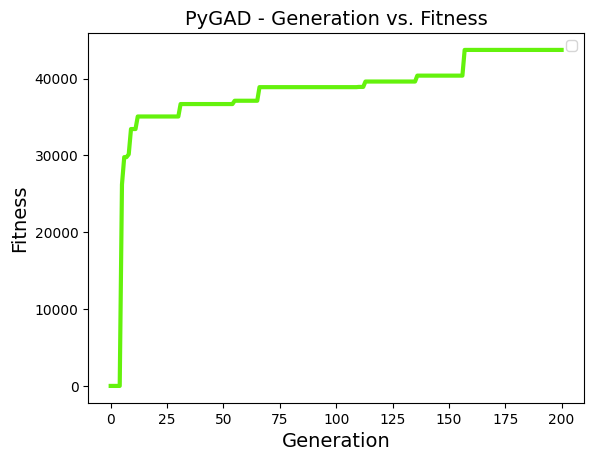

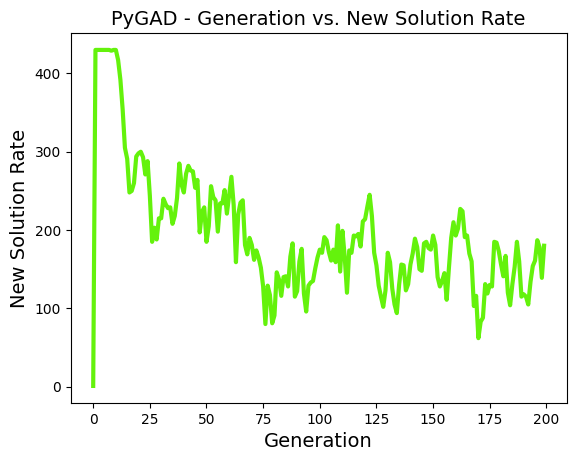

Parameters of the best solution :
 [0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1]
Fitness value of the best solution = 43735.59000001
 object: Cell phone 
 price: 2199.12 
 required space: 8.99e-06 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook C 
 price: 39

Time of running the genetic algorithm: 27.74 min


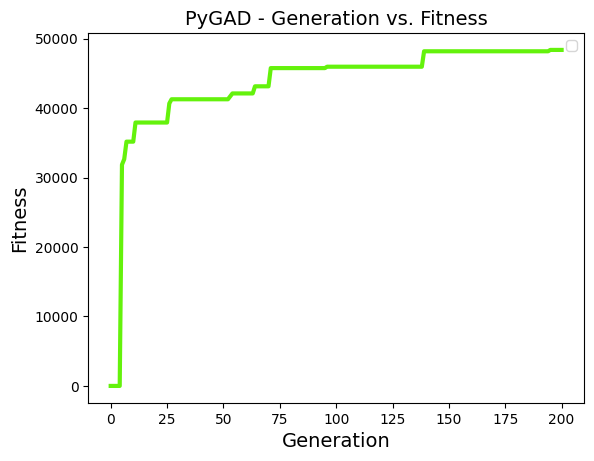

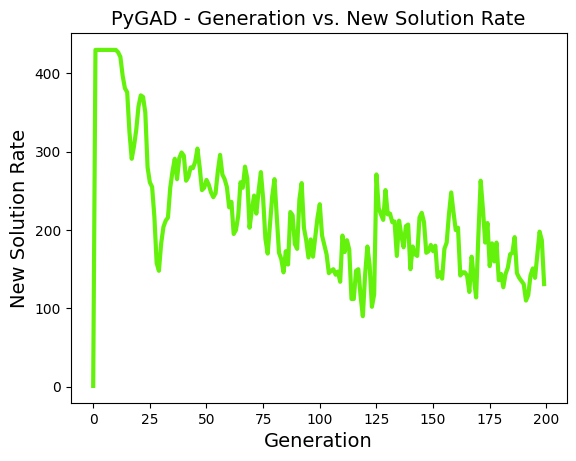

Parameters of the best solution :
 [0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0]
Fitness value of the best solution = 48383.46000001
 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook C 
 price: 3999.0 
 required space: 0.527 



 object: Notebook C 
 price: 3999.0 
 req

Time of running the genetic algorithm: 28.05 min


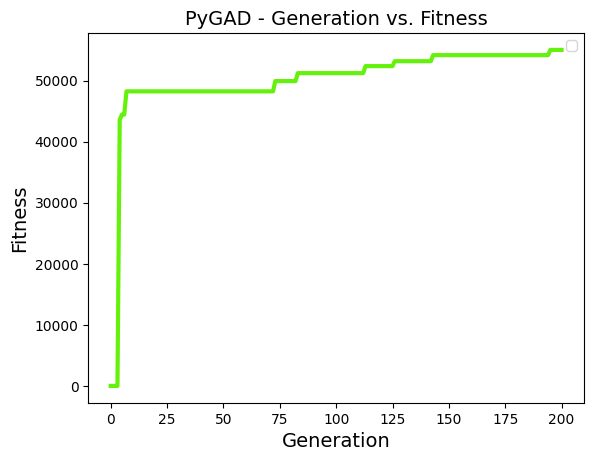

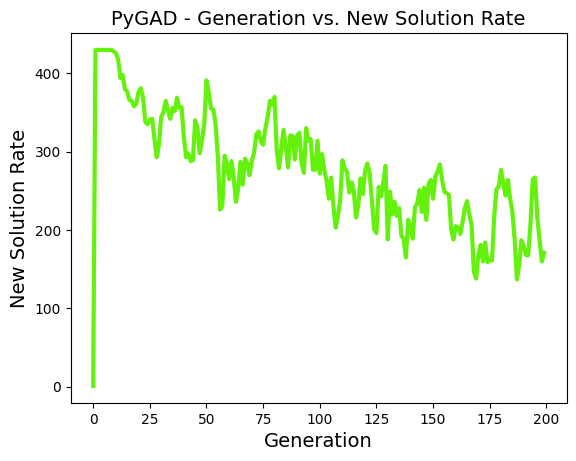

Parameters of the best solution :
 [0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 1]
Fitness value of the best solution = 55034.37000001001
 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook C 
 price: 3999.0 
 require

In [ ]:
# now we will redefine attributes of TransportationGeneticOptimization Class according to the best results
# obviously crossover type is scattered (3/3), crossover_probability is 0.8 (2/3),
# mutation_probability is 0.7 (2/3), which leaves us with mutation_percent_genes equals 50

algorithm.crossover_type = algorithm.params_df.iloc[65]['crossover_type']
algorithm.crossover_probability = algorithm.params_df.iloc[65]['crossover_probability']
algorithm.mutation_probability = algorithm.params_df.iloc[65]['mutation_probability']
algorithm.mutation_percent_genes = algorithm.params_df.iloc[65]['mutation_percent_genes']

# let's try different values for van capacity and run our algorithm again for each one and save our results

for VAN_VOLUME in range(1, 6):
    print('Van capacity: ', VAN_VOLUME)
    algorithm.run_algorithm()
    algorithm.show_items_included()
    print('----------')
    print()


We can see from our obtained results, that with increasing the capacity of the van the occured error inreases linearly. We can see it from the new solution rate graph and from total required space values, which in the further cases become more distant from what it should be. We can also see that fitness of the solution has a potential to increase more during further generations. (fitness/generation graph). Time consumed by the algorithm also increases according to the van capacity - the more space - the more time.
Let's see what we can obtain by increasing number of generations linearly along with increasing the van volume.

Van capacity:  1
Number of generations 300
Time of running the genetic algorithm: 41.56 min


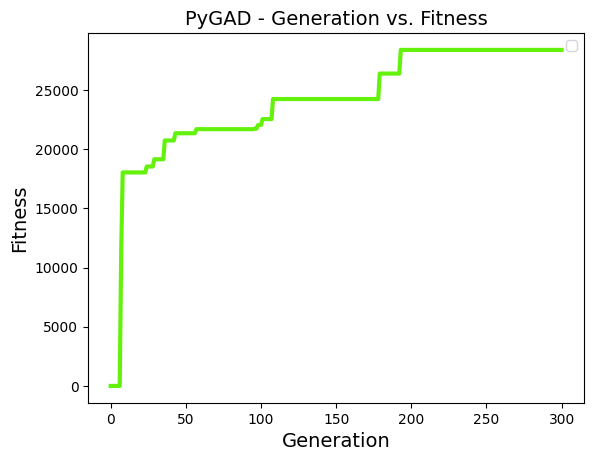

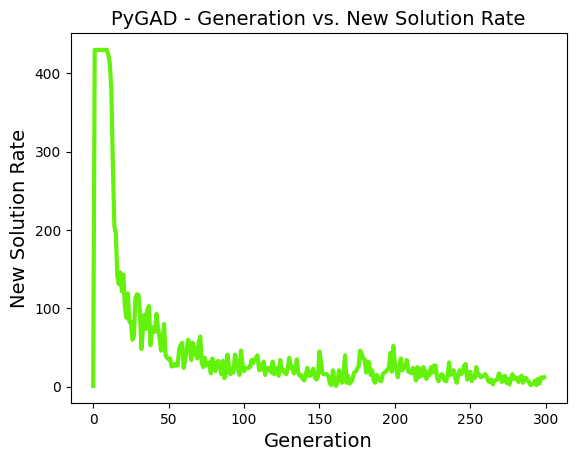

Parameters of the best solution :
 [0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Fitness value of the best solution = 28395.640000010004
 object: Cell phone 
 price: 2199.12 
 required space: 8.99e-06 



 object: Cell phone 
 price: 2199.12 
 required space: 8.99e-06 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



Total occupied space 0.9940179799999997
Total value of the transported objects 28395.640000000007
----------



In [ ]:

# let's try different values for van capacity and run our algorithm again for each one and save our results
VAN_VOLUME = 1
print('Van capacity: ', VAN_VOLUME)
algorithm.num_generations = (100 * VAN_VOLUME + 200)
print('Number of generations', algorithm.num_generations)
algorithm.run_algorithm()
algorithm.show_items_included()
print('----------')
print()

Here it was possible to repeat best result from parameter search, though this is not a given. Nevertheless the probability to obtain such result is respectively high and with this parameters fitness did not desсend less than 20000 for van capacity equals 1.  

Van capacity:  2
Number of generations 400


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1162: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Time of running the genetic algorithm: 101.32 min


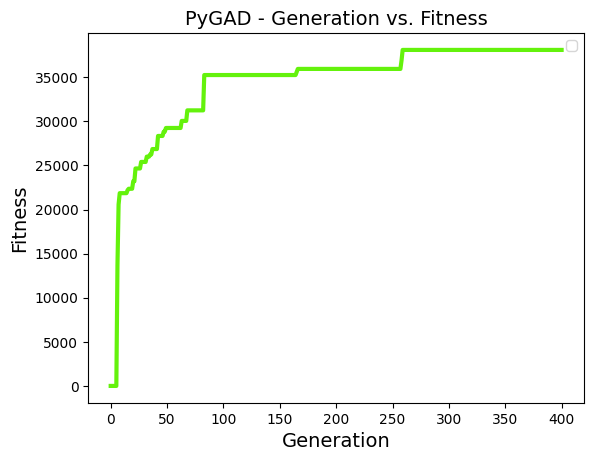

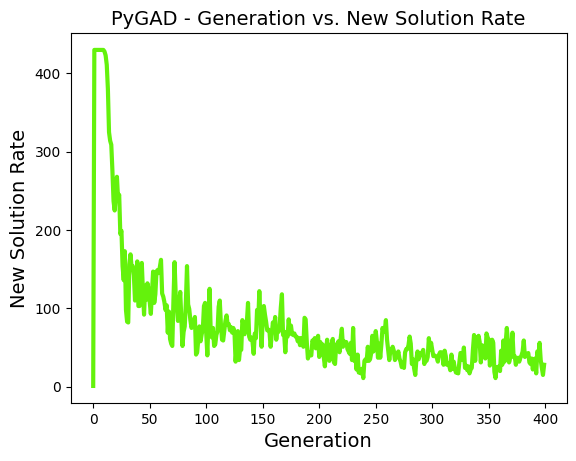

Parameters of the best solution :
 [0 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Fitness value of the best solution = 38090.52000001001
 object: Cell phone 
 price: 2199.12 
 required space: 8.99e-06 



 object: Cell phone 
 price: 2199.12 
 required space: 8.99e-06 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



Total occ

In [ ]:
VAN_VOLUME = 2
print('Van capacity: ', VAN_VOLUME)
algorithm.num_generations = (100 * VAN_VOLUME + 200)
print('Number of generations', algorithm.num_generations)
algorithm.run_algorithm()
algorithm.show_items_included()
print('----------')
print()

Van capacity:  3
Number of generations 500


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1162: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Time of running the genetic algorithm: 203.49 min


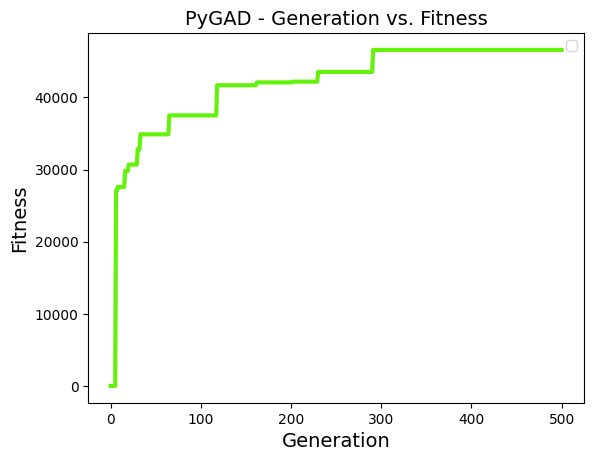

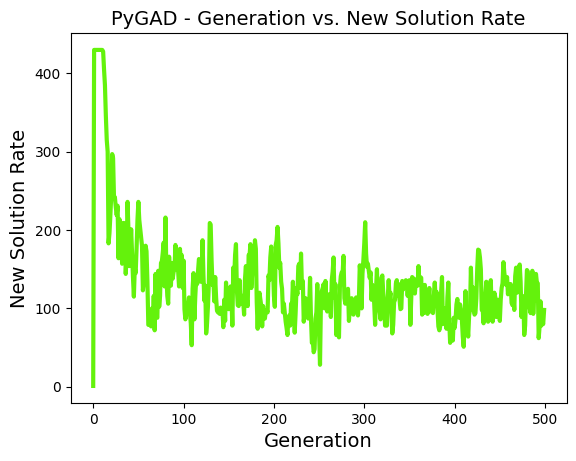

Parameters of the best solution :
 [0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0]
Fitness value of the best solution = 46588.52000001001
 object: Cell phone 
 price: 2199.12 
 required space: 8.99e-06 



 object: Cell phone 
 price: 2199.12 
 required space: 8.99e-06 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 pr

In [ ]:
VAN_VOLUME = 3
print('Van capacity: ', VAN_VOLUME)
algorithm.num_generations = (100 * VAN_VOLUME + 200)
print('Number of generations', algorithm.num_generations)
algorithm.run_algorithm()
algorithm.show_items_included()
print('----------')
print()

Van capacity:  4
Number of generations 600


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1162: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Time of running the genetic algorithm: 313.44 min


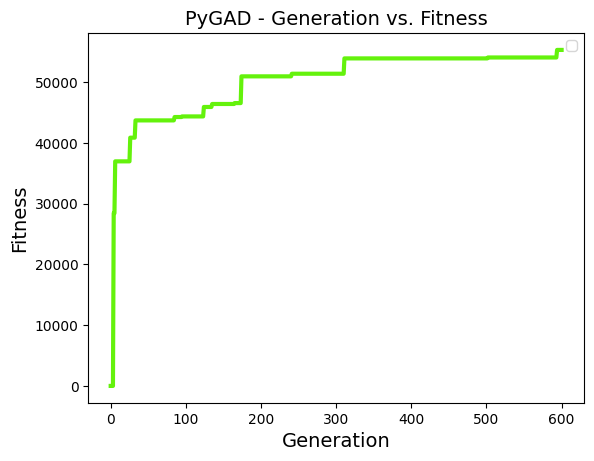

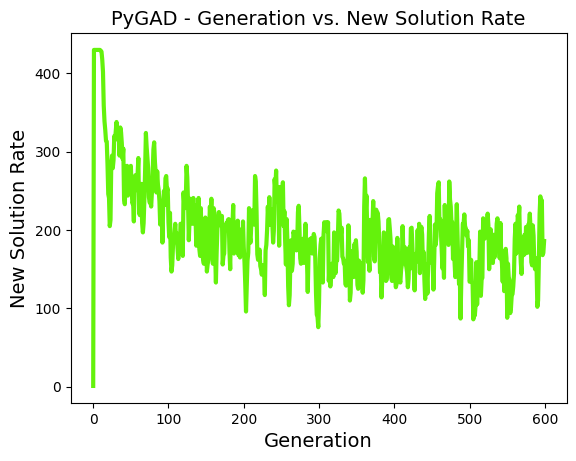

Parameters of the best solution :
 [0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0]
Fitness value of the best solution = 55281.60000001001
 object: Cell phone 
 price: 2199.12 
 required space: 8.99e-06 



 object: Cell phone 
 price: 2199.12 
 required space: 8.99e-06 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 24

In [ ]:
VAN_VOLUME = 4
print('Van capacity: ', VAN_VOLUME)
algorithm.num_generations = (100 * VAN_VOLUME + 200)
print('Number of generations', algorithm.num_generations)
algorithm.run_algorithm()
algorithm.show_items_included()
print('----------')
print()

Van capacity:  5
Number of generations 700


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1162: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Time of running the genetic algorithm: 365.13 min


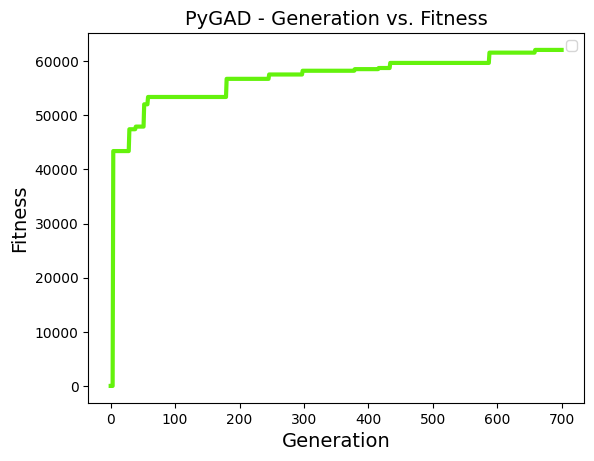

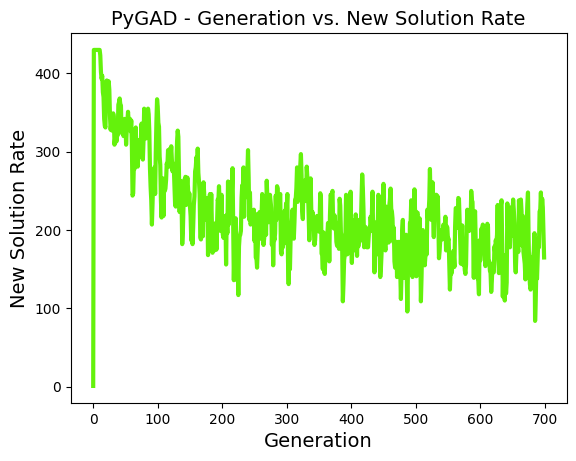

Parameters of the best solution :
 [0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 1]
Fitness value of the best solution = 62082.28000001001
 object: Cell phone 
 price: 2199.12 
 required space: 8.99e-06 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 55 
 price: 4346.99 
 required space: 0.4 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 50 
 price: 3999.9 
 required space: 0.29 



 object: TV 42 
 price: 2999.0 
 required space: 0.2 



 object: Notebook A 
 price: 2499.9 
 required space: 0.0035 



 object: Notebook A 
 price: 2499.9 
 re

In [ ]:
VAN_VOLUME = 5
print('Van capacity: ', VAN_VOLUME)
algorithm.num_generations = (100 * VAN_VOLUME + 200)
print('Number of generations', algorithm.num_generations)
algorithm.run_algorithm()
algorithm.show_items_included()
print('----------')
print()

We can see that despite the error becomes smaller in comparison with the first experiment, it still increases along with van capacity, also fitness requires more generations to develop for example for van capacity equals 5.

We can also say that the algorithm tends to be stuck at local minimas, that's why parameters which provide more randomness for the genetic algorithm perform better (parent selection type, mutation type).
The best crossover type was scattered  which creates a random binary chromosomes and selects the genes where the chromosome is 1 from the first parent, and the genes where the chromosome is 0 from the second parent and later combines the genes to form a child.

All results (final datasets, dataset with parameters) are saved in respective folder.